In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.2.0


In [2]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [3]:
# inspecting WellHeader_Datathon.csv
Dataframe = pd.read_csv("../../../data/WellHeader_Datathon.csv")
Dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10437 entries, 0 to 10436
Data columns (total 89 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EPAssetsId                 10437 non-null  int64  
 1   Province                   10437 non-null  object 
 2   LicenceNumber              10437 non-null  object 
 3   UWI                        10437 non-null  object 
 4   CurrentOperator            10437 non-null  object 
 5   CurrentOperatorParent      10437 non-null  int64  
 6   CurrentOperatorParentName  10437 non-null  object 
 7   Licensee                   10437 non-null  object 
 8   LicenseeParentCompany      10437 non-null  int64  
 9   LicenseeParentCompanyName  10437 non-null  object 
 10  LicenceDate                10437 non-null  object 
 11  CurrentStatus              10437 non-null  object 
 12  CurrentStatusStandardised  10437 non-null  object 
 13  WellType                   10437 non-null  obj

In [4]:
# calculating horizontal distance
def Lat_dist_calculator(Surf_Longitude, Surf_Latitude, BH_Longitude, BH_Latitude, R=6373.0):
    from math import sin, cos, sqrt, atan2, radians
    # approximate radius of earth in km
    #R = 6373.0
    lat_dist = []
    for n in range(len(Surf_Latitude)):
        lat1 = radians(Surf_Latitude[n])
        lon1 = radians(Surf_Longitude[n])
        lat2 = radians(BH_Latitude[n])
        lon2 = radians(BH_Longitude[n])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        lat_dist.append(R*c*1000)
    return lat_dist
Dataframe['LatDistance'] = Lat_dist_calculator(Dataframe['Surf_Longitude'], Dataframe['Surf_Latitude'], Dataframe['BH_Longitude'], Dataframe['BH_Latitude'], R=6373.0)

In [5]:
# correcting vertical wells
Dataframe.WellProfile[Dataframe.LatDistance.values == 0] = 'Vertical'
Dataframe.TVD[Dataframe.WellProfile.values == 'Vertical'] = Dataframe['TotalDepth']
Dataframe.LatDistance[Dataframe.WellProfile.values == 'Vertical'] = 0

In [6]:
# calculating TVD aproximation
def TVD_aproximation(TotalDepth, LatDistance, Formation, WellProfile):
    from math import sqrt
    TVD_a = []
    for n in range(len(TotalDepth)):
        td = TotalDepth[n]
        ld = LatDistance[n]
        if WellProfile[n] != 'Vertical':
            TVD = abs(td-ld)
        else:
            TVD = TotalDepth[n]
        TVD_a.append(TVD)
    return TVD_a
Dataframe['TVD_aprox'] = TVD_aproximation(Dataframe['TotalDepth'], Dataframe['LatDistance'], Dataframe['Formation'], Dataframe['WellProfile'])

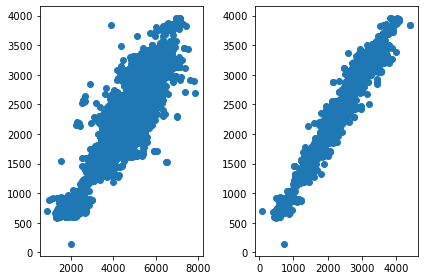

In [7]:
plt.subplot(1, 2, 1)
plt.scatter(Dataframe['TotalDepth'].where(Dataframe['WellProfile']!='Vertical'), Dataframe['TVD'])
plt.subplot(1, 2, 2)
plt.scatter(Dataframe['TVD_aprox'].where(Dataframe['WellProfile']!='Vertical'), Dataframe['TVD'])
plt.tight_layout()

In [8]:
# selecting working variables for TVD estimation from WellHeader_Datathon.csv
Dataframe = Dataframe[['EPAssetsId', 'Surf_Longitude', 'Surf_Latitude', 'DaysDrilling', 'KBElevation', 'Formation', 'WellProfile', 'TVD_aprox', 'TVD']]

#Dataframe = pd.read_csv("../../../data/WellHeader_Datathon.csv")[['EPAssetsId', 'Surf_Longitude', 'Surf_Latitude', 'BH_Longitude', 'BH_Latitude', 'GroundElevation', 'KBElevation', 'TotalDepth', 'DaysDrilling', 'WellProfile', 'Formation', 'Field', 'Pool', 'LaheeClass', 'PSACAreaCode', 'Surf_Location', 'BH_Location', 'TVD']] # little improvement, possible overfitting

# casting categorilac data
Dataframe[Dataframe.dtypes[Dataframe.dtypes == 'object'].index] = Dataframe[Dataframe.dtypes[Dataframe.dtypes == 'object'].index].astype('category')

In [9]:
# one hot encoder for categories
ohe = OneHotEncoder(sparse=False)
Dataframe_ohe = pd.DataFrame(ohe.fit_transform(Dataframe[Dataframe.dtypes[Dataframe.dtypes == 'category'].index]), columns=ohe.get_feature_names(Dataframe.dtypes[Dataframe.dtypes == 'category'].index))
# adding numerical columns
Dataframe_ohe = pd.concat([Dataframe[Dataframe.dtypes[Dataframe.dtypes != 'category'].index], Dataframe_ohe], axis=1)
Dataframe_ohe.set_index('EPAssetsId', inplace=True)

In [10]:
# dropping wells not in target fields
#Dataframe_ohe = Dataframe_ohe[Dataframe_ohe.index.get_level_values('EPAssetsId').isin(pd.read_csv("../../../data/WellHeader_Datathon.csv")[['EPAssetsId','Field']][pd.read_csv("../../../data/WellHeader_Datathon.csv")[['EPAssetsId','Field']]['Field'].isin(pd.read_csv("../../../data/WellHeader_Datathon.csv")[['EPAssetsId','Field']].where(pd.read_csv("../../../data/WellHeader_Datathon.csv").EPAssetsId.isin(pd.read_csv("../../../data/WellHeader_Datathon.csv")['EPAssetsId'][pd.read_csv("../../../data/WellHeader_Datathon.csv")['EPAssetsId'].isin(pd.read_csv("../../../data/Submission_Sample.csv")['EPAssetsId'])])).dropna()['Field'])]['EPAssetsId'])]

# dropping vertical wells
Dataframe_ohe = Dataframe_ohe[Dataframe_ohe.WellProfile_Vertical.values == 0]

# dropping wells not in target formations
#Dataframe_ohe = Dataframe_ohe[Dataframe_ohe.Formation_Cardium.values == 0]

# dropping categorical columns after filtering
Dataframe_ohe = Dataframe_ohe.drop(columns=['WellProfile_Vertical'])
#Dataframe_ohe = Dataframe_ohe.drop(columns=['WellProfile_Vertical', 'WellProfile_Directional', 'WellProfile_Horizontal'])
#Dataframe_ohe = Dataframe_ohe.drop(columns=['WellProfile_Vertical', 'Formation_Cardium'])
#Dataframe_ohe = Dataframe_ohe.drop(columns=['Formation_Duvernay', 'Formation_Montney', 'Formation_Viking', 'Formation_Cardium'])

# turning long to positive
Dataframe_ohe['Surf_Longitude'] = Dataframe_ohe['Surf_Longitude']*(-1)
#Dataframe_ohe['BH_Longitude'] = Dataframe_ohe['BH_Longitude']*(-1)

# lat / long normalization   
#Dataframe_ohe['Surf_Latitude'] = (Dataframe_ohe['Surf_Latitude'] - Dataframe_ohe['Surf_Latitude'].min())/(Dataframe_ohe['Surf_Latitude'].max() - Dataframe_ohe['Surf_Latitude'].min())
#Dataframe_ohe['Surf_Longitude'] = (Dataframe_ohe['Surf_Longitude'] - Dataframe_ohe['Surf_Longitude'].min())/(Dataframe_ohe['Surf_Longitude'].max() - Dataframe_ohe['Surf_Longitude'].min())
#Dataframe_ohe['BH_Latitude'] = (Dataframe_ohe['BH_Latitude'] - Dataframe_ohe['BH_Latitude'].min())/(Dataframe_ohe['BH_Latitude'].max() - Dataframe_ohe['BH_Latitude'].min())
#Dataframe_ohe['BH_Longitude'] = (Dataframe_ohe['BH_Longitude'] - Dataframe_ohe['BH_Longitude'].min())/(Dataframe_ohe['BH_Longitude'].max() - Dataframe_ohe['BH_Longitude'].min())

In [11]:
# generating train and target dataframes
Dataframe_train = Dataframe_ohe[~Dataframe_ohe.TVD.isna()]
Dataframe_train = Dataframe_train.loc[Dataframe_train.TVD_aprox-Dataframe_train.TVD < Dataframe_train.TVD*0.5]
#Dataframe_train = Dataframe_train.drop(columns=['TVD_aprox'])

# target datasets
Dataframe_target = Dataframe_ohe[Dataframe_ohe.TVD.isna()]
Dataframe_target_test = Dataframe_target[Dataframe_target.index.get_level_values('EPAssetsId').isin(pd.read_csv("../../../data/Submission_Sample.csv")['EPAssetsId'])]

In [12]:
# binning dataset based on its distribution
Dataframe_train_bin1 = Dataframe_train.loc[Dataframe_train.TVD_aprox <= 1000]
Dataframe_train_bin2 = Dataframe_train.loc[Dataframe_train.TVD_aprox > 1000]
Dataframe_train_bin3 = Dataframe_train.loc[(Dataframe_train.TVD_aprox >= 1000) & (Dataframe_train.WellProfile_Horizontal == 1)]

Dataframe_target_bin1 = Dataframe_target.loc[Dataframe_target.TVD_aprox <= 1000]
Dataframe_target_bin2 = Dataframe_target.loc[Dataframe_target.TVD_aprox > 1000]
Dataframe_target_bin3 = Dataframe_target.loc[(Dataframe_target.TVD_aprox >= 1000) & (Dataframe_target.WellProfile_Horizontal == 1)]

Dataframe_target_test_bin1 = Dataframe_target_test.loc[Dataframe_target_test.TVD_aprox <= 1000]
Dataframe_target_test_bin2 = Dataframe_target_test.loc[Dataframe_target_test.TVD_aprox > 1000]
Dataframe_target_test_bin3 = Dataframe_target_test.loc[(Dataframe_target_test.TVD_aprox >= 1000) & (Dataframe_target_test.WellProfile_Horizontal == 1)]

# second droping stage
#Dataframe_train_bin1 = Dataframe_train_bin1.drop(columns=['Formation_Montney', 'Formation_Duvernay'])
#Dataframe_target_bin1 = Dataframe_target_bin1.drop(columns=['Formation_Viking', 'Formation_Duvernay'])
#Dataframe_target_test_bin1 = Dataframe_target_test_bin1.drop(columns=['Formation_Montney', 'Formation_Viking'])

In [13]:
Dataframe_train.head()

,Surf_Longitude,Surf_Latitude,DaysDrilling,KBElevation,TVD_aprox,TVD,Formation_Cardium,Formation_Duvernay,Formation_Montney,Formation_Viking,WellProfile_Directional,WellProfile_Horizontal
EPAssetsId,,,,,,,,,,,,
2593278,117.527042,54.737446,13.0,770.8,1871.724542,1954.58,0.0,0.0,1.0,0.0,0.0,1.0
2579437,117.559923,54.730864,13.0,759.4,1835.299852,1940.06,0.0,0.0,1.0,0.0,0.0,1.0
2591761,117.560141,54.730703,12.0,759.8,1825.969316,1945.01,0.0,0.0,1.0,0.0,0.0,1.0
2587302,117.561283,54.723339,11.0,767.7,1819.576739,1956.34,0.0,0.0,1.0,0.0,0.0,1.0
2600942,117.639433,54.787071,7.0,725.0,1769.087497,1911.62,0.0,0.0,1.0,0.0,0.0,1.0


In [14]:
Dataframe_target.head()

,Surf_Longitude,Surf_Latitude,DaysDrilling,KBElevation,TVD_aprox,TVD,Formation_Cardium,Formation_Duvernay,Formation_Montney,Formation_Viking,WellProfile_Directional,WellProfile_Horizontal
EPAssetsId,,,,,,,,,,,,
2587301,117.529866,54.747632,13.0,764.8,2076.977070,NaN,0.0,0.0,1.0,0.0,0.0,1.0
2608978,117.482119,54.745328,9.0,807.4,2131.682328,NaN,0.0,0.0,1.0,0.0,0.0,1.0
2608702,116.965662,54.578063,52.0,787.0,2921.202299,NaN,0.0,1.0,0.0,0.0,0.0,1.0
2614267,116.965540,54.578117,59.0,787.0,3162.949943,NaN,0.0,1.0,0.0,0.0,1.0,0.0
2608700,116.965908,54.577954,36.0,787.0,3095.550036,NaN,0.0,1.0,0.0,0.0,0.0,1.0


In [15]:
# analysing relationship between numerical features and target
#for var in Dataframe[Dataframe.dtypes[Dataframe.dtypes != 'category'].index].columns:
#    plt.scatter(Dataframe[var], Dataframe.TVD,  color='blue')
#    plt.xlabel(var)
#    plt.ylabel("TVD")
#    plt.show()

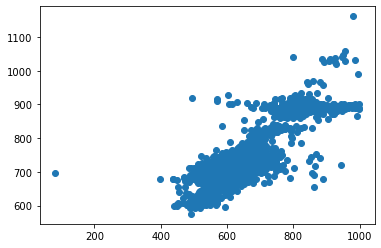

In [16]:
plt.scatter(Dataframe_train_bin1['TVD_aprox'], Dataframe_train_bin1['TVD'])
#plt.xlim([0,8000])

(0.0, 8000.0)

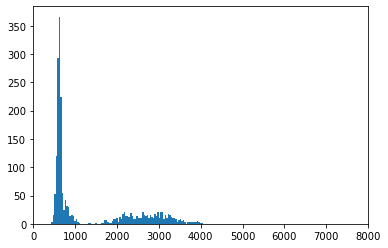

In [17]:
plt.hist(Dataframe_target_test['TVD_aprox'], bins = 100)
plt.xlim([0,8000])

In [18]:
# spliting the sample and test data
sample_x, test_x, sample_y, test_y = train_test_split(Dataframe_train.loc[:, Dataframe_train.columns != 'TVD'], Dataframe_train.TVD, test_size=0.1, random_state=42)

# spliting the training and validation data
train_x, validation_x, train_y, validation_y = train_test_split(sample_x, sample_y, test_size=0.3, random_state=42)

# features scaling
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
validation_x = sc.transform(validation_x)
test_x = sc.transform(test_x)

In [19]:
# spliting the sample and test data
sample_x1, test_x1, sample_y1, test_y1 = train_test_split(Dataframe_train_bin1.loc[:, Dataframe_train_bin1.columns != 'TVD'], Dataframe_train_bin1.TVD, test_size=0.1, random_state=42)
sample_x2, test_x2, sample_y2, test_y2 = train_test_split(Dataframe_train_bin2.loc[:, Dataframe_train_bin2.columns != 'TVD'], Dataframe_train_bin2.TVD, test_size=0.1, random_state=42)
sample_x3, test_x3, sample_y3, test_y3 = train_test_split(Dataframe_train_bin3.loc[:, Dataframe_train_bin3.columns != 'TVD'], Dataframe_train_bin3.TVD, test_size=0.1, random_state=42)

# spliting the training and validation data
train_x1, validation_x1, train_y1, validation_y1 = train_test_split(sample_x1, sample_y1, test_size=0.3, random_state=42)
train_x2, validation_x2, train_y2, validation_y2 = train_test_split(sample_x2, sample_y2, test_size=0.3, random_state=42)
train_x3, validation_x3, train_y3, validation_y3 = train_test_split(sample_x3, sample_y3, test_size=0.3, random_state=42)

# features scaling
sc1 = StandardScaler()
sc2 = StandardScaler()
sc3 = StandardScaler()

#sample_x1 = sc.transform(sample_x1)
#sample_x2 = sc.transform(sample_x2)
#sample_x3 = sc.transform(sample_x3)
#sample_x1 = sc1.fit_transform(sample_x1)
#sample_x2 = sc2.fit_transform(sample_x2)
#sample_x3 = sc3.fit_transform(sample_x3)

train_x1 = sc1.fit_transform(train_x1)
train_x2 = sc2.fit_transform(train_x2)
train_x3 = sc3.fit_transform(train_x3)

validation_x1 = sc1.transform(validation_x1)
validation_x2 = sc2.transform(validation_x2)
validation_x3 = sc3.transform(validation_x3)

test_x1 = sc1.transform(test_x1)
test_x2 = sc2.transform(test_x2)
test_x3 = sc3.transform(test_x3)

In [20]:
# setting steps per epochs
STEPS_PER_EPOCH = 20

In [21]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.0001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks():
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=10000,),
    tf.keras.callbacks.TensorBoard('./_model_deep/tensorboard_logs'),]

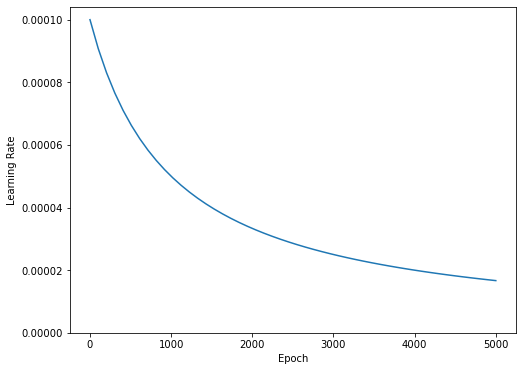

In [22]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [23]:
# a simple custom activation
from keras import backend as BK

def mapping_to_target_range(x, target_min=0, target_max=5000):
    x02 = BK.tanh(x)+1 # x in range(0,2)
    scale = (target_max-target_min)/2.
    return  x02*scale+target_min

def mapping_to_target_range_bin1(x, target_min=0, target_max=4000):
    x02 = BK.tanh(x)+1 # x in range(0,2)
    scale = (target_max-target_min)/2.
    return  x02*scale+target_min

def mapping_to_target_range_bin2(x, target_min=0, target_max=4000):
    x02 = BK.tanh(x)+1 # x in range(0,2)
    scale = (target_max-target_min)/2.
    return  x02*scale+target_min

def mapping_to_target_range_bin3(x, target_min=0, target_max=3850):
    x02 = BK.tanh(x)+1 # x in range(0,2)
    scale = (target_max-target_min)/2.
    return  x02*scale+target_min

In [24]:
# define regression model
def regression_model_deep(shape, model='deep' , optimizer=None):
    # simple model
    if model == 'simple':
        model = tf.keras.Sequential()
        model.add(layers.Dense(270, activation='relu', input_shape=(shape,)))
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(135, activation='relu'))
        model.add(layers.Dropout(0.1))
        #model.add(layers.Dense(40, activation='relu'))
        #model.add(layers.Dropout(0.01))
        #model.add(layers.Dense(1, activation=mapping_to_target_range))
        #model.add(layers.Lambda(lambda x: x * [2]))
        model.add(layers.Dense(1))
        if optimizer is None:
            optimizer = get_optimizer()
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
        return model

    # deep model v1
    elif model == 'deep':
        final_model_v1 = tf.keras.Sequential([
        layers.Dense(2048, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu', input_shape=(shape,)),
        layers.Dropout(0.2),
        layers.Dense(1024, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu'),
        layers.Dropout(0.01),
        layers.Dense(1)
        ])
        # compile model
        if optimizer is None:
            optimizer = get_optimizer()
        final_model_v1.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
        return final_model_v1
    
    # deep model v2
    if model == 'deepv2':
        final_model_v2 = tf.keras.Sequential([
        layers.Dense(2048, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu', input_shape=(shape,)),
        layers.Dropout(0.5),
        layers.Dense(2048, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu', input_shape=(shape,)),
        layers.Dropout(0.25),
        layers.Dense(1024, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1024, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu'),
        layers.Dropout(0.01),
        layers.Dense(1)
        ])
        if optimizer is None:
            optimizer = get_optimizer()
        final_model_v2.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
        return final_model_v2

In [28]:
# load model from previous training
#modelv2 = tf.keras.models.load_model('./_model_deep/modelv2.h5')

In [26]:
if 'histories' not in locals():
    histories = {}

In [27]:
# max number of epochs
max_epochs=20000

In [32]:
# build the model 1
#model_l3000 = regression_model_deep(sample_x1.shape[1], model='deep')

# model 1
histories['model_t3000'] = model_l3000.fit(x = train_x1, y = train_y1,
                                    steps_per_epoch = STEPS_PER_EPOCH,
                                    epochs=max_epochs,
                                    validation_data=(validation_x1, validation_y1),
                                    callbacks=get_callbacks(),
                                    verbose=0, workers=12, use_multiprocessing=True)


Epoch: 0, loss:300.7625,  mean_squared_error:300.4137,  val_loss:142.3967,  val_mean_squared_error:142.0479,  
....................................................................................................
Epoch: 100, loss:310.4532,  mean_squared_error:310.1036,  val_loss:143.1651,  val_mean_squared_error:142.8155,  
....................................................................................................
Epoch: 200, loss:283.9286,  mean_squared_error:283.5786,  val_loss:140.4448,  val_mean_squared_error:140.0948,  
....................................................................................................
Epoch: 300, loss:302.3148,  mean_squared_error:301.9642,  val_loss:139.4913,  val_mean_squared_error:139.1408,  
....................................................................................................
Epoch: 400, loss:296.2705,  mean_squared_error:295.9194,  val_loss:138.2899,  val_mean_squared_error:137.9388,  
................................

In [51]:
# build the model 2
#model_h3000 = regression_model_deep(sample_x2.shape[1], model='deepv2')

# model 2
histories['model_h3000'] = model_h3000.fit(x = train_x2, y = train_y2,
                                    steps_per_epoch = STEPS_PER_EPOCH,
                                    epochs=max_epochs,
                                    validation_data=(validation_x2, validation_y2),
                                    callbacks=get_callbacks(),
                                    verbose=0, workers=12, use_multiprocessing=True)


Epoch: 0, loss:5666.4360,  mean_squared_error:5662.2905,  val_loss:1086.0740,  val_mean_squared_error:1081.9280,  
....................................................................................................
Epoch: 100, loss:5145.7974,  mean_squared_error:5141.6494,  val_loss:1065.1514,  val_mean_squared_error:1061.0033,  
....................................................................................................
Epoch: 200, loss:5304.5234,  mean_squared_error:5300.3740,  val_loss:1098.8112,  val_mean_squared_error:1094.6621,  
....................................................................................................
Epoch: 300, loss:5007.7900,  mean_squared_error:5003.6406,  val_loss:1076.4131,  val_mean_squared_error:1072.2629,  
....................................................................................................
Epoch: 400, loss:5312.8320,  mean_squared_error:5308.6797,  val_loss:1039.3629,  val_mean_squared_error:1035.2107,  
............

In [248]:
# build the model for bin3
#model_h3000_hor = regression_model_deep(sample_x3.shape[1], model='deep')

# model 3
#histories['model_h3000_hor'] = model_h3000_hor.fit(x = train_x3, y = train_y3, steps_per_epoch = STEPS_PER_EPOCH, epochs=max_epochs, validation_data=(validation_x3, validation_y3), callbacks=get_callbacks(), verbose=0, workers=12, use_multiprocessing=True)


Epoch: 0, loss:7387813.5000,  mean_squared_error:7387812.5000,  val_loss:4670693.5000,  val_mean_squared_error:4670690.5000,  
....................................................................................................
Epoch: 100, loss:4265.2393,  mean_squared_error:4261.5239,  val_loss:2725.5996,  val_mean_squared_error:2721.8896,  
....................................................................................................
Epoch: 200, loss:3612.9348,  mean_squared_error:3609.3286,  val_loss:2224.4761,  val_mean_squared_error:2220.8633,  
....................................................................................................
Epoch: 300, loss:4025.3442,  mean_squared_error:4021.7319,  val_loss:2524.8486,  val_mean_squared_error:2521.2292,  
....................................................................................................
Epoch: 400, loss:3698.7273,  mean_squared_error:3695.0527,  val_loss:1617.4502,  val_mean_squared_error:1613.7747,  


In [31]:
# build the model for all samples
#model = regression_model_deep(sample_x.shape[1], model='deep')

# model all
histories['model'] = model.fit(x = train_x, y = train_y,
                                    steps_per_epoch = STEPS_PER_EPOCH,
                                    epochs=max_epochs,
                                    validation_data=(validation_x, validation_y),
                                    callbacks=get_callbacks(),
                                    verbose=0, workers=12, use_multiprocessing=True)

.........
Epoch: 800, loss:944.1057,  mean_squared_error:930.0245,  val_loss:333.1344,  val_mean_squared_error:319.0533,  
....................................................................................................
Epoch: 900, loss:931.6965,  mean_squared_error:917.6135,  val_loss:346.7328,  val_mean_squared_error:332.6490,  
....................................................................................................
Epoch: 1000, loss:936.1287,  mean_squared_error:922.0385,  val_loss:370.4949,  val_mean_squared_error:356.4063,  
....................................................................................................
Epoch: 1100, loss:929.5520,  mean_squared_error:915.4542,  val_loss:349.4821,  val_mean_squared_error:335.3847,  
....................................................................................................
Epoch: 1200, loss:1013.2574,  mean_squared_error:999.1490,  val_loss:351.0092,  val_mean_squared_error:336.9008,  
.................

In [29]:
# build the model for all samples
#modelv2 = regression_model_deep(sample_x.shape[1], model='deepv2')

# model all v2
histories['modelv2'] = modelv2.fit(x = train_x, y = train_y,
                                    steps_per_epoch = STEPS_PER_EPOCH,
                                    epochs=max_epochs,
                                    validation_data=(validation_x, validation_y),
                                    callbacks=get_callbacks(),
                                    verbose=0, workers=12, use_multiprocessing=True)

......................................................................................
Epoch: 1400, loss:1339.4010,  mean_squared_error:1338.6731,  val_loss:481.3807,  val_mean_squared_error:480.6528,  
....................................................................................................
Epoch: 1500, loss:1274.0596,  mean_squared_error:1273.3318,  val_loss:518.5859,  val_mean_squared_error:517.8578,  
....................................................................................................
Epoch: 1600, loss:1348.4576,  mean_squared_error:1347.7292,  val_loss:484.1882,  val_mean_squared_error:483.4598,  
....................................................................................................
Epoch: 1700, loss:1289.0190,  mean_squared_error:1288.2906,  val_loss:608.2167,  val_mean_squared_error:607.4883,  
....................................................................................................
Epoch: 1800, loss:1279.5874,  mean_squared_er

(0.0, 1500.0)

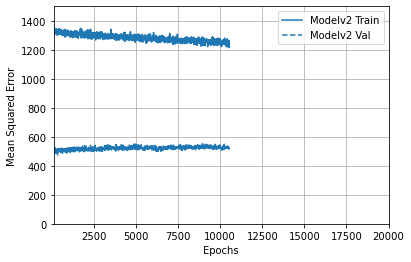

In [30]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_squared_error', smoothing_std=10)
plotter.plot(histories)
plt.xlim([100, 20000])
plt.ylim([0, 1500])

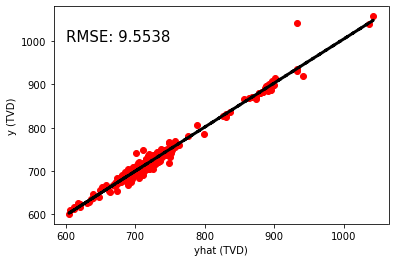

In [41]:
# validation
yhat1 = model_l3000.predict(test_x1)

#yhat1 = model.predict(sc.transform(test_x))

RMSE = mean_squared_error(yhat1, test_y1, squared=False)

# poly1d_fn is a function which takes in yhat values and returns an estimate for y
coef = np.polyfit(yhat1.flat, test_y1,1)
poly1d_fn = np.poly1d(coef)

# correlation y/yhat
plt.scatter(yhat1, test_y1, color='Red')
plt.plot(yhat1 , poly1d_fn(yhat1), '--k', linewidth=3,)
plt.xlabel("yhat (TVD)")
plt.ylabel("y (TVD)")
plt.text(600, 1000, r'RMSE: {:.4f}'.format(RMSE), fontsize=15)
plt.show()

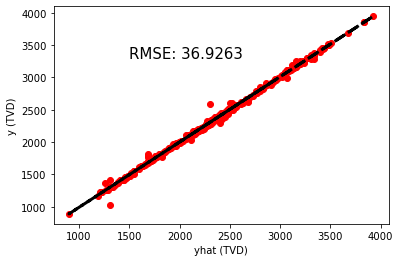

In [54]:
yhat2 = model_h3000.predict(test_x2)

RMSE = mean_squared_error(yhat2, test_y2, squared=False)

# poly1d_fn is a function which takes in yhat values and returns an estimate for y
coef = np.polyfit(yhat2.flat, test_y2,1)
poly1d_fn = np.poly1d(coef)

# correlation y/yhat
plt.scatter(yhat2, test_y2, color='Red')
plt.plot(yhat2 , poly1d_fn(yhat2), '--k', linewidth=3,)
plt.xlabel("yhat (TVD)")
plt.ylabel("y (TVD)")
plt.text(1500, 3300, r'RMSE: {:.4f}'.format(RMSE), fontsize=15)
plt.show()

In [28]:
#yhat3 = model_h3000_hor.predict(test_x3)

#RMSE = mean_squared_error(yhat3, test_y3, squared=False)

# poly1d_fn is a function which takes in yhat values and returns an estimate for y
#coef = np.polyfit(yhat3.flat, test_y3,1)
#poly1d_fn = np.poly1d(coef)

# correlation y/yhat
#plt.scatter(yhat3, test_y3, color='Red')
#plt.plot(yhat3 , poly1d_fn(yhat3), '--k', linewidth=3,)
#plt.xlabel("yhat (TVD)")
#plt.ylabel("y (TVD)")
#plt.text(1500, 3300, r'RMSE: {:.4f}'.format(RMSE), fontsize=15)
#plt.show()

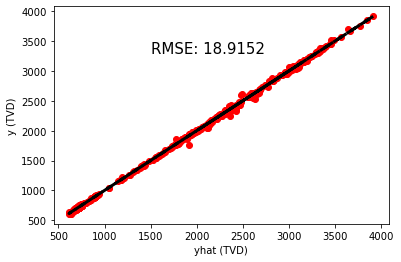

In [34]:
yhat = model.predict(test_x)

RMSE = mean_squared_error(yhat, test_y, squared=False)

# poly1d_fn is a function which takes in yhat values and returns an estimate for y
coef = np.polyfit(yhat.flat, test_y,1)
poly1d_fn = np.poly1d(coef)

# correlation y/yhat
plt.scatter(yhat, test_y, color='Red')
plt.plot(yhat , poly1d_fn(yhat), '--k', linewidth=3,)
plt.xlabel("yhat (TVD)")
plt.ylabel("y (TVD)")
plt.text(1500, 3300, r'RMSE: {:.4f}'.format(RMSE), fontsize=15)
plt.show()

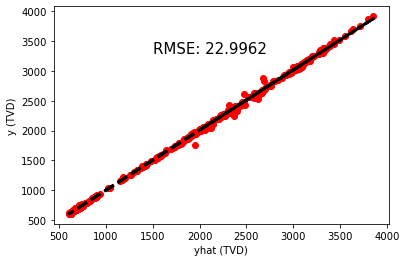

In [32]:
yhat = modelv2.predict(test_x)

RMSE = mean_squared_error(yhat, test_y, squared=False)

# poly1d_fn is a function which takes in yhat values and returns an estimate for y
coef = np.polyfit(yhat.flat, test_y,1)
poly1d_fn = np.poly1d(coef)

# correlation y/yhat
plt.scatter(yhat, test_y, color='Red')
plt.plot(yhat , poly1d_fn(yhat), '--k', linewidth=3,)
plt.xlabel("yhat (TVD)")
plt.ylabel("y (TVD)")
plt.text(1500, 3300, r'RMSE: {:.4f}'.format(RMSE), fontsize=15)
plt.show()

In [37]:
# saving model
#model.save('./_model_deep/model.h5')
#modelv2.save('./_model_deep/modelv2.h5')
#model_l3000.save('./_model_deep/model_l3000.h5')
#model_h3000.save('./_model_deep/model_h3000.h5')
#model_h3000_hor.save('./_model_deep/model_h3000_hor.h5')

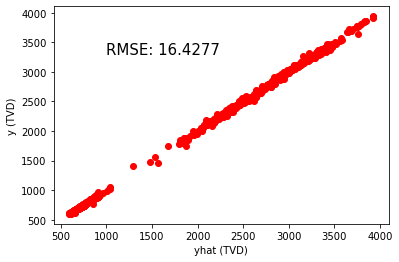

In [55]:
# prediction for partial submission (1963 wells)

#Dataframe_target_test['TVD'] = model.predict(sc.transform(Dataframe_target_test.loc[:, Dataframe_target_test.columns != 'TVD']))

Dataframe_target_test_bin1['TVD'] = model_l3000.predict(sc1.transform(Dataframe_target_test_bin1.loc[:, Dataframe_target_test_bin1.columns != 'TVD']))
Dataframe_target_test_bin2['TVD'] = model_h3000.predict(sc2.transform(Dataframe_target_test_bin2.loc[:, Dataframe_target_test_bin2.columns != 'TVD']))
#Dataframe_target_test_bin3['TVD'] = model_h3000_hor.predict(sc3.transform(Dataframe_target_test_bin3.loc[:, Dataframe_target_test_bin3.columns != 'TVD']))

Dataframe_target_test['TVD'] = np.NaN
Dataframe_target_test.loc[Dataframe_target_test['TVD'].isnull(), 'TVD'] = Dataframe_target_test_bin1['TVD']
Dataframe_target_test.loc[Dataframe_target_test['TVD'].isnull(), 'TVD'] = Dataframe_target_test_bin2['TVD']
#Dataframe_target_test.loc[Dataframe_target_test['TVD'].isnull(), 'TVD'] = Dataframe_target_test_bin3['TVD']

RMSE = mean_squared_error(Dataframe_target_test['TVD'], pd.read_csv("../../../data/tvd_conqueros9.csv").TVD, squared=False)

# correlation y/yhat
plt.scatter(Dataframe_target_test['TVD'], pd.read_csv("../../../data/tvd_conqueros9.csv").TVD, color='Red')
plt.xlabel("yhat (TVD)")
plt.ylabel("y (TVD)")
plt.text(1000, 3300, r'RMSE: {:.4f}'.format(RMSE), fontsize=15)
plt.show()

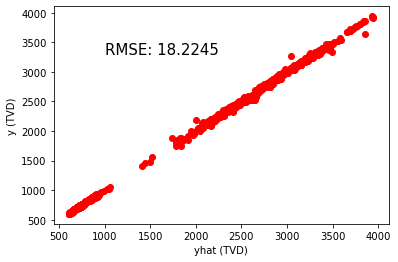

In [35]:
Dataframe_target_test['TVD'] = model.predict(sc.transform(Dataframe_target_test.loc[:, Dataframe_target_test.columns != 'TVD']))

RMSE = mean_squared_error(Dataframe_target_test['TVD'], pd.read_csv("../../../data/tvd_conqueros9.csv").TVD, squared=False)

# correlation y/yhat
plt.scatter(Dataframe_target_test['TVD'], pd.read_csv("../../../data/tvd_conqueros9.csv").TVD, color='Red')
plt.xlabel("yhat (TVD)")
plt.ylabel("y (TVD)")
plt.text(1000, 3300, r'RMSE: {:.4f}'.format(RMSE), fontsize=15)
plt.show()

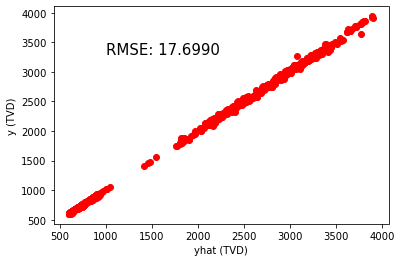

In [33]:
Dataframe_target_test['TVD'] = modelv2.predict(sc.transform(Dataframe_target_test.loc[:, Dataframe_target_test.columns != 'TVD']))

RMSE = mean_squared_error(Dataframe_target_test['TVD'].sort_index(), pd.read_csv("../../../data/tvd_conqueros9.csv").set_index('EPAssetsId').TVD.sort_index(), squared=False)

# correlation y/yhat
plt.scatter(Dataframe_target_test['TVD'], pd.read_csv("../../../data/tvd_conqueros9.csv").set_index('EPAssetsId').TVD, color='Red')
plt.xlabel("yhat (TVD)")
plt.ylabel("y (TVD)")
plt.text(1000, 3300, r'RMSE: {:.4f}'.format(RMSE), fontsize=15)
plt.show()

In [36]:
# preparing and saving partial Submission.csv
#Dataframe_target_test['TVD'] = yhat_submission
Dataframe_target_test['TVD'].to_csv('Partial_Submission.csv', index=True)

In [417]:
# prediction for total submission (1963 wells)
yhat_submission = model_deep.predict(sc.transform(Dataframe_target.loc[:, Dataframe_target.columns != 'TVD']))

In [418]:
# preparing and saving total Submission.csv
Dataframe_target['TVD'] = yhat_submission
Dataframe_target['TVD'].to_csv('Total_Submission.csv', index=True)